/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Sharpe: Strategy 0.128, Benchmark 0.115
Cumulative Return: Strategy 0.60%, Benchmark 0.36%
Max Drawdown: Strategy -18.98%, Benchmark -19.01%
Volatility Ratio: 1.000


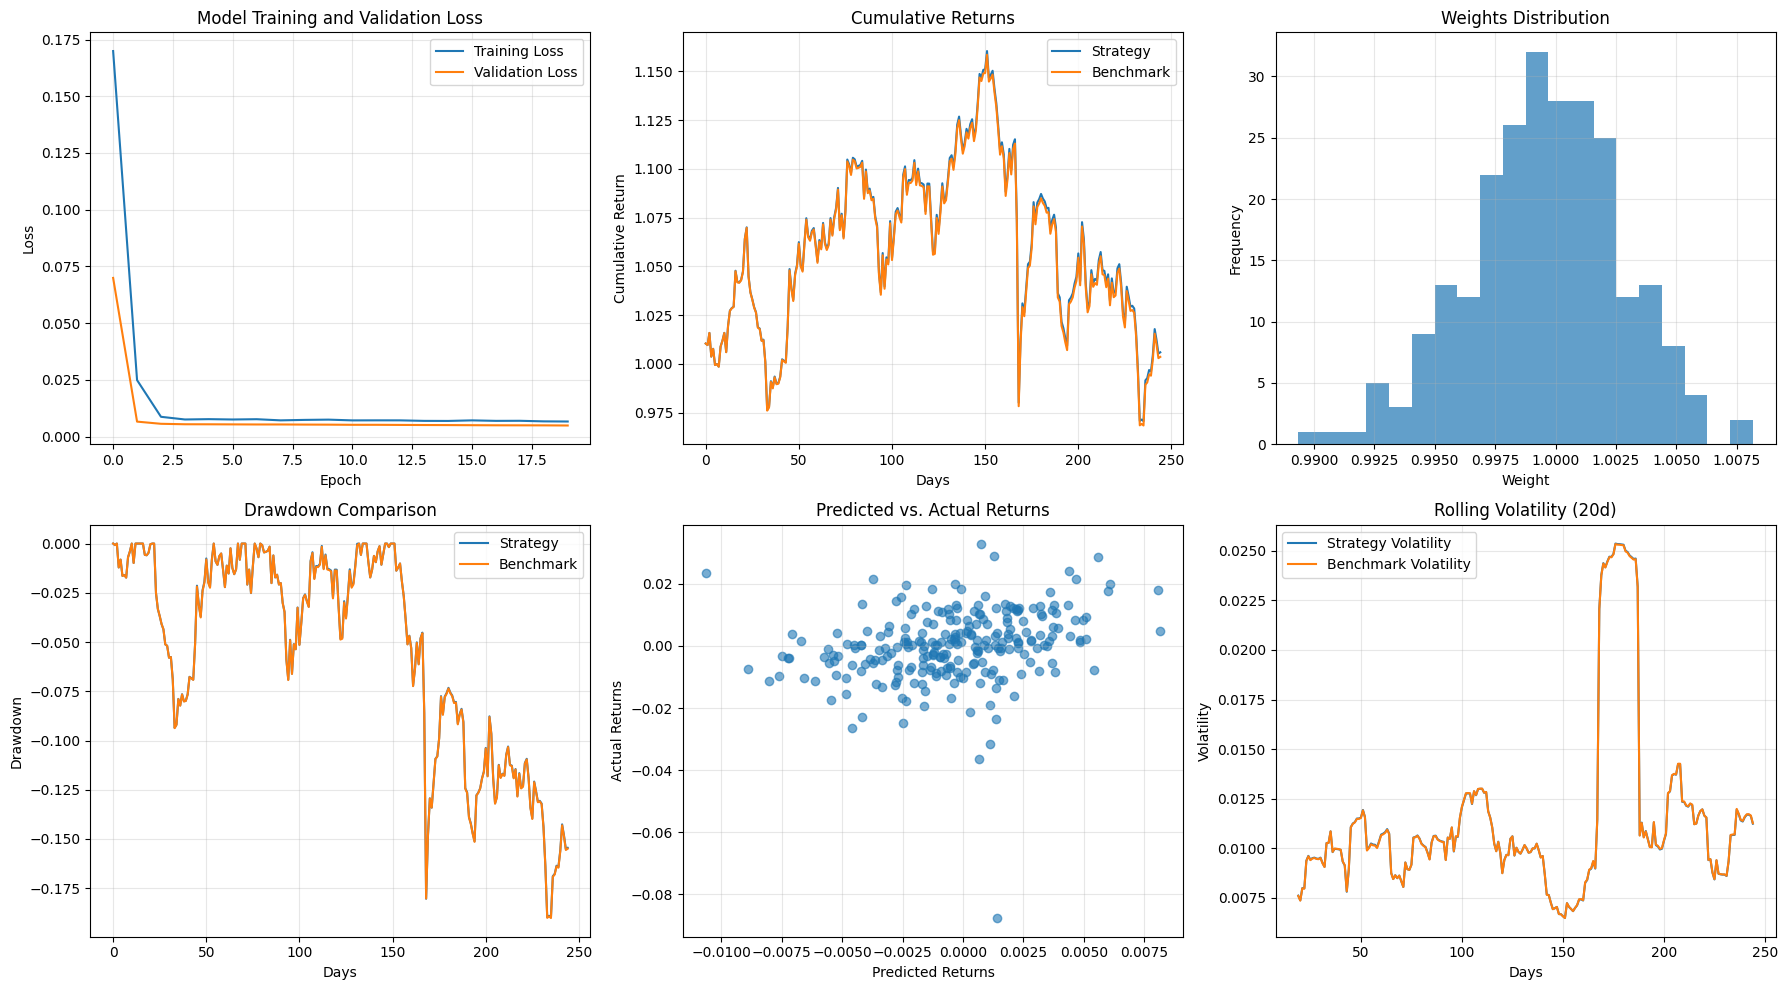

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import Input  #caught some errors

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    #to sent away warnings of tensorflow


np.random.seed(42)  #seeds for reproducibility
tf.random.set_seed(42)

#KOSPI prediction pipeline
ticker = '^KS11'
data = yf.download(ticker, start='2019-12-04', end='2024-12-04', progress=False, auto_adjust=False).reset_index() #taking data of 5 years
data['Date'] = pd.to_datetime(data['Date'])

#features
data['returns'] = data['Close'].pct_change()
data['excess_returns'] = data['returns']  #we think risk-free = 0
data['target_excess_ret'] = data['excess_returns'].shift(-3)  #predicting 3day ahead 
data['ret_5d'] = data['Close'].pct_change(5)
data['vol_5d'] = data['returns'].rolling(5).std()
data['vol_ratio'] = data['Volume'] / data['Volume'].rolling(5).mean()
data['momentum'] = data['ret_5d'] / (data['vol_5d'] + 1e-8)  #momentum proxy with epsilon to not divide by zero 

data = data.dropna()  #using full dataset for better robustness

features = ['ret_5d', 'vol_5d', 'vol_ratio', 'momentum']
X = data[features].values
y = data['target_excess_ret'].values
actual_returns = data['excess_returns'].values

scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

split_idx = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]
test_returns = actual_returns[split_idx:]

#reshaping
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

#model train single LSTM + a bit of dense
model = models.Sequential([layers.LSTM(64, input_shape=(1, 4)),
                           layers.Dropout(0.2),  #regularization
                           layers.Dense(16, activation='relu'),
                           layers.Dense(1)])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0, validation_split=0.1)   #history for loss plot

y_pred = scaler_y.inverse_transform(model.predict(X_test).flatten().reshape(-1, 1)).flatten()

#weights 
weights = 2 / (1 + np.exp(-y_pred * 2))      #adding weights as in project (0-2)
strategy_returns = weights * test_returns
benchmark_returns = test_returns

#volatility constraint
strategy_vol = np.std(strategy_returns)
benchmark_vol = np.std(benchmark_returns)
vol_ratio = strategy_vol / benchmark_vol
if vol_ratio > 1.2:
    scale_factor = 1.2 / vol_ratio
    weights *= scale_factor
    strategy_returns = weights * test_returns
    new_vol_ratio = np.std(strategy_returns) / benchmark_vol
    if new_vol_ratio > 1.2:
        weights *= (1.2 / new_vol_ratio)
        strategy_returns = weights * test_returns

#metrics
sharpe = lambda r: np.mean(r) / np.std(r) * np.sqrt(252) if np.std(r) > 0 else 0
strategy_sharpe = sharpe(strategy_returns)
benchmark_sharpe = sharpe(benchmark_returns)
cum_ret = lambda r: (1 + r).prod() - 1
strategy_cum = cum_ret(strategy_returns)
benchmark_cum = cum_ret(benchmark_returns)
mdd = lambda r: ((1 + r).cumprod() - np.maximum.accumulate((1 + r).cumprod())).min()
strategy_mdd = mdd(strategy_returns)
benchmark_mdd = mdd(benchmark_returns)

print(f"Sharpe: Strategy {strategy_sharpe:.3f}, Benchmark {benchmark_sharpe:.3f}")
print(f"Cumulative Return: Strategy {strategy_cum:.2%}, Benchmark {benchmark_cum:.2%}")
print(f"Max Drawdown: Strategy {strategy_mdd:.2%}, Benchmark {benchmark_mdd:.2%}")
print(f"Volatility Ratio: {vol_ratio:.3f}")

#visualisations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

#1 training and validation loss
axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Model Training and Validation Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

#2 cumulative returns
axes[0, 1].plot((1 + strategy_returns).cumprod(), label='Strategy')
axes[0, 1].plot((1 + benchmark_returns).cumprod(), label='Benchmark')
axes[0, 1].set_title('Cumulative Returns')
axes[0, 1].set_xlabel('Days')
axes[0, 1].set_ylabel('Cumulative Return')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

#3 weights distribution
axes[0, 2].hist(weights, bins=20, alpha=0.7)
axes[0, 2].set_title('Weights Distribution')
axes[0, 2].set_xlabel('Weight')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].grid(True, alpha=0.3)

#4 drawdown comparison
strategy_dd = (1 + strategy_returns).cumprod() - np.maximum.accumulate((1 + strategy_returns).cumprod())
benchmark_dd = (1 + benchmark_returns).cumprod() - np.maximum.accumulate((1 + benchmark_returns).cumprod())
axes[1, 0].plot(strategy_dd, label='Strategy')
axes[1, 0].plot(benchmark_dd, label='Benchmark')
axes[1, 0].set_title('Drawdown Comparison')
axes[1, 0].set_xlabel('Days')
axes[1, 0].set_ylabel('Drawdown')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

#5 prediction and true values scatter plot
axes[1, 1].scatter(y_pred, test_returns, alpha=0.6)
axes[1, 1].set_title('Predicted vs. Actual Returns')
axes[1, 1].set_xlabel('Predicted Returns')
axes[1, 1].set_ylabel('Actual Returns')
axes[1, 1].grid(True, alpha=0.3)

#6 volatility by time passing 
strategy_vol_ts = pd.Series(strategy_returns).rolling(20).std() #20d for smoothness
benchmark_vol_ts = pd.Series(benchmark_returns).rolling(20).std()
axes[1, 2].plot(strategy_vol_ts, label='Strategy Volatility')
axes[1, 2].plot(benchmark_vol_ts, label='Benchmark Volatility')
axes[1, 2].set_title('Rolling Volatility (20d)')
axes[1, 2].set_xlabel('Days')
axes[1, 2].set_ylabel('Volatility')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()